Testing Guney's `toolbox` package for network based proximity between drug targets and disease genes.

Chosen targets:
* Hydroxychloroquine targets (TLR7 and TLR9)
* two of the AD disease genes

AD disease genes:
* Guney AD genes: from Guney et al
* Knowledge based AD genes: from the DISEASES database
* High confidence AD genes: knowledge based + TWAS + incipient proteomic signature

Both choices of targets are rather arbitrary.  We expect the two AD disease genes, by definition, to be more proximal than the Hydroxychloroquine targets (which are not AD genes by any definition used in this notebook). The calculations below will support this quantitatively.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from toolbox import wrappers
from toolbox import network_utilities
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils

GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


## Preparations

### GeneID -- Symbol mapping

`id_mapping_file` comes from [this file](ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz) at NCBI; see [parse_ncbi.py](https://github.com/attilagk/guney_code/blob/master/parse_ncbi.py) for details.

In [2]:
id_mapping_file = '../../resources/PPI/geneid_to_symbol.txt'
id_symbol = pd.read_csv(id_mapping_file, sep='\t', index_col='GeneID')
id_symbol = id_symbol.set_index(id_symbol.index.astype('str'))
id_symbol

,Symbol
GeneID,
1,A1BG
2,A2M
3,A2MP1
9,NAT1
10,NAT2
...,...
8923215,trnD
8923216,trnP
8923217,trnA


### PPI networks

I read two PPI networks:
1. `network_guney` from Guney et al 2016
1. `network_cheng` from Cheng et al 2019

Below is the number of binary PPI interactions in each of these networks

In [3]:
%%bash
wc -l ../../resources/proximity/data/network/network.sif ../../resources/PPI/Cheng2019/network.sif

 141296 ../../resources/proximity/data/network/network.sif
 217160 ../../resources/PPI/Cheng2019/network.sif
 358456 total


In [4]:
network_guney = wrappers.get_network('../../resources/proximity/data/network/network.sif', only_lcc = True)
network_cheng = wrappers.get_network('../../resources/PPI/Cheng2019/network.sif', only_lcc = True)

### HCQ targets
I will use Hydroxychloroquine's targets.  See [this page](https://go.drugbank.com/drugs/DB01611) on drugbank.

In [5]:
%%bash
echo TLR7 > ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets
echo TLR9 >> ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets

In [6]:
HCQ_targets_TLR = wrappers.convert_to_geneid(file_name='../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets', id_type='symbol', id_mapping_file=id_mapping_file)
HCQ_targets_TLR

set()


{'51284', '54106'}

In [7]:
%%bash
echo ACE2 >> ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets

In [8]:
HCQ_targets = wrappers.convert_to_geneid(file_name='../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets', id_type='symbol', id_mapping_file=id_mapping_file)
HCQ_targets

set()


{'51284', '54106', '59272'}

### AD gene sets
#### Guney AD genes

In [9]:
%%bash
grep 'alzheimer disease' ../../resources/proximity/data/disease/disease_genes.tsv | \
tr '\t' '\n' | sed -n '/^[0-9]\+/ p' > ../../results/2021-08-04-guney-tools/AD-genes-guney

In [10]:
with open('../../results/2021-08-04-guney-tools/AD-genes-guney') as f:
    AD_genes_guney = f.readlines()
AD_genes_guney = [x.strip('\n') for x in AD_genes_guney]

Making sure that the gene set is a subset of the network's nodes

In [11]:
def remove_genes_notin_network(genes, network):
    oldsize = len(genes)
    newgenes = [y for y in genes if y in network.nodes]
    newsize = len(newgenes)
    restgenes = set(genes).difference(set(newgenes))
    print(oldsize - newsize, 'genes removed from', oldsize)
    return((newgenes, restgenes))

AD_genes_guney, AD_genes_guney_removed = remove_genes_notin_network(AD_genes_guney, network_cheng)

5 genes removed from 36


When I use the older, smaller `network_guney` then additional genes are removed (therefore I won't use `network_guney`).

In [12]:
AD_genes_guney1, AD_genes_guney_removed1 = remove_genes_notin_network(AD_genes_guney, network_guney)

2 genes removed from 31


#### Knowledge based AD genes

This is a gene set whose size is similar to `AD_genes_guney` but this set comes from other source of evidence (arguably more reliable source when we consider that knowledge bases contain manually curated genes based on experimental evidence).

In [13]:
AD_genes_knowledge = wrappers.convert_to_geneid(file_name='../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge', id_type='symbol', id_mapping_file=id_mapping_file)

{'MT-ND1', 'MT-ND2'}


In [14]:
AD_genes_knowledge, AD_genes_knowledge_removed = remove_genes_notin_network(AD_genes_knowledge, network_cheng)

0 genes removed from 24


#### High confidence AD genes

In [15]:
AD_genes_HC = wrappers.convert_to_geneid(file_name='../../results/2021-07-01-high-conf-ADgenes/AD-genes-seed', id_type='symbol', id_mapping_file=id_mapping_file)

{'MT-ND2', 'ENSG00000260911', 'ENSG00000270081.1', 'MT-ND1', 'X84075'}


In [16]:
AD_genes_HC, AD_genes_HC_removed = remove_genes_notin_network(AD_genes_HC, network_cheng)

11 genes removed from 103


## Results

### Overlap between AD gene sets

Relationship of various AD gene sets are plotted below

['named-figure/AD-gene-sets-venn2.png', 'named-figure/AD-gene-sets-venn2.pdf']

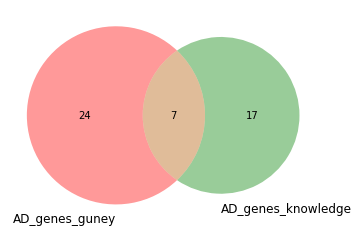

In [17]:
G = set(AD_genes_guney)
K = set(AD_genes_knowledge)
H = set(AD_genes_HC)

partition = dict()
partition['10'] = G.difference(K)
partition['01'] = K.difference(G)
partition['11'] = G.intersection(K)
subsets = {k: len(v) for k, v in partition.items()}
fig, ax = plt.subplots()
venn2(subsets=subsets, set_labels=('AD_genes_guney', 'AD_genes_knowledge'))
attila_utils.savefig(fig, 'AD-gene-sets-venn2')

The intersection contains APP, APOE and PSEN1, PSEN2.

['named-figure/AD-gene-sets-venn3.png', 'named-figure/AD-gene-sets-venn3.pdf']

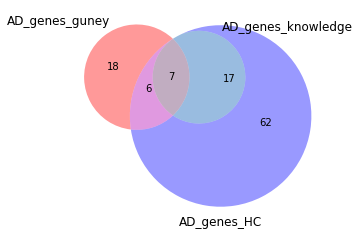

In [18]:
partition = dict()
partition['100'] = G.difference(K.union(H))
partition['010'] = K.difference(G.union(H))
partition['001'] = H.difference(G.union(K))
partition['110'] = G.intersection(K).difference(H)
partition['101'] = G.intersection(H).difference(K)
partition['011'] = K.intersection(H).difference(G)
partition['111'] = G.intersection(K).intersection(H)
subsets = {k: len(v) for k, v in partition.items()}
fig, ax = plt.subplots()
venn3(subsets=subsets, set_labels=('AD_genes_guney', 'AD_genes_knowledge', 'AD_genes_HC'))
attila_utils.savefig(fig, 'AD-gene-sets-venn3')

In [19]:
G_knowledge = network_utilities.get_neighborhood_subgraph(network_cheng, AD_genes_knowledge)
degrees_knowledge = network_utilities.get_node_degree_related_values(G_knowledge, set())

In [20]:
dk = pd.DataFrame(degrees_knowledge).transpose().rename({0: 'd', 1: 'ld', 2: 'd2', 3: 'ld2'}, axis=1)
ik = id_symbol.loc[list(set(AD_genes_guney).intersection(set(AD_genes_knowledge))), ]
pd.concat([ik, dk.loc[ik.index, ]], axis=1)

,Symbol,d,ld,d2,ld2
GeneID,,,,,
348,APOE,62,0,2882,0
10347,ABCA7,5,0,1985,0
5663,PSEN1,108,0,2917,0
1191,CLU,82,0,2858,0
351,APP,1967,0,3020,0
55103,RALGPS2,5,0,2014,0
5664,PSEN2,68,0,2841,0


In [21]:
G_HCQ = network_utilities.get_neighborhood_subgraph(network_cheng, HCQ_targets)
degrees_HCQ = network_utilities.get_node_degree_related_values(G_HCQ, set())

Let's calculate the degree of TLR7 and TLR9!

In [22]:
dh = pd.DataFrame(degrees_HCQ).transpose().rename({0: 'd', 1: 'ld', 2: 'd2', 3: 'ld2'}, axis=1)
ih = id_symbol.loc[HCQ_targets, ]
pd.concat([ih, dh.loc[ih.index, ]], axis=1)

,Symbol,d,ld,d2,ld2
GeneID,,,,,
51284,TLR7,6,0,19,0
59272,ACE2,5,0,10,0
54106,TLR9,28,0,33,0


I select ABCA7 and APOE, two AD genes with comparable degrees to TLR7 and TLR9, respectively:

In [23]:
AD_2genes = ['10347', '348']

### Proximity

Now the proximity calculation between `HCQ_targets` and `AD_genes_guney`

In [24]:
res_guney = wrappers.calculate_proximity(network=network_cheng, nodes_from=HCQ_targets, nodes_to=AD_genes_guney)

In [25]:
res_guney

(2.3333333333333335,
 1.4736516197184548,
 (2.0096666666666665, 0.21963580966884452))

The distance $d = 2.0$ whereas $z \approx 0.106$ so we can conclude that `HCQ_targets` are not significantly proximal to `AD_genes_guney`.  Note that $z < -2$ would indicate statistically significant proximity.

In [26]:
res_guney_prox = wrappers.calculate_proximity(network=network_cheng, nodes_from=AD_2genes, nodes_to=AD_genes_guney)

In [27]:
res_guney_prox

(0.0, -6.384836658430075, (1.9305, 0.3023569909891286))



Thus the small `AD_genes_guney` gene set (31 genes) does not support Hydroxychloroquine's repurposing for AD.  Below I study other AD gene sets that might be better than `AD_genes_guney`.

In [28]:
res_knowledge = wrappers.calculate_proximity(network=network_cheng, nodes_from=HCQ_targets, nodes_to=AD_genes_knowledge)

In [29]:
res_knowledge

(2.3333333333333335, 1.6040615818701227, (1.978, 0.22152100477281056))

In [30]:
res_HC = wrappers.calculate_proximity(network=network_cheng, nodes_from=HCQ_targets, nodes_to=AD_genes_HC)

In [31]:
res_HC

(2.0, 0.5852559796020538, (1.8593333333333335, 0.24035066973995403))

### Changing targets

#### 2 AD genes

In [32]:
res_knowledge_prox = wrappers.calculate_proximity(network=network_cheng, nodes_from=AD_2genes, nodes_to=AD_genes_knowledge)

In [33]:
res_knowledge_prox

(0.0, -5.72552492748579, (1.8655, 0.3258216536696111))

In [34]:
res_HC_prox = wrappers.calculate_proximity(network=network_cheng, nodes_from=AD_2genes, nodes_to=AD_genes_HC)

In [35]:
res_HC_prox

(0.0, -5.334161147185035, (1.686, 0.3160759402422146))

#### HCQ targets (only TLRs)

In [36]:
res_guney_TLR = wrappers.calculate_proximity(network=network_cheng, nodes_from=HCQ_targets_TLR, nodes_to=AD_genes_guney)
res_knowledge_TLR = wrappers.calculate_proximity(network=network_cheng, nodes_from=HCQ_targets_TLR, nodes_to=AD_genes_knowledge)
res_HC_TLR = wrappers.calculate_proximity(network=network_cheng, nodes_from=HCQ_targets_TLR, nodes_to=AD_genes_HC)

## Summary

In [37]:
ix = pd.MultiIndex.from_product([ ('HCQ targets', 'HCQ t: TLRs', '2 AD genes'), ('Guney', 'Knowledge', 'HC')])
prox = pd.DataFrame(index=ix)
prox.loc[('HCQ targets', 'Guney'), ['distance', 'z-score']] = res_guney[:2]
prox.loc[('HCQ targets', 'Knowledge'), ['distance', 'z-score']] = res_knowledge[:2]
prox.loc[('HCQ targets', 'HC'), ['distance', 'z-score']] = res_HC[:2]

prox.loc[('HCQ t: TLRs', 'Guney'), ['distance', 'z-score']] = res_guney_TLR[:2]
prox.loc[('HCQ t: TLRs', 'Knowledge'), ['distance', 'z-score']] = res_knowledge_TLR[:2]
prox.loc[('HCQ t: TLRs', 'HC'), ['distance', 'z-score']] = res_HC_TLR[:2]

prox.loc[('2 AD genes', 'Guney'), ['distance', 'z-score']] = res_guney_prox[:2]
prox.loc[('2 AD genes', 'Knowledge'), ['distance', 'z-score']] = res_knowledge_prox[:2]
prox.loc[('2 AD genes', 'HC'), ['distance', 'z-score']] = res_HC_prox[:2]

prox['p-value'] = prox['z-score'].apply(lambda x: scipy.stats.norm.sf(-x))
prox['- log10 p'] = - np.log10(prox['p-value'])
prox = prox.rename_axis(['target', 'AD genes'], axis=0)
prox['target'] = prox.index.get_level_values('target')
prox['AD genes'] = prox.index.get_level_values('AD genes')
prox

distance   z-score       p-value  - log10 p  \
target      AD genes                                                 
HCQ targets Guney      2.333333  1.473652  9.297123e-01   0.031651   
            Knowledge  2.333333  1.604062  9.456498e-01   0.024270   
            HC         2.000000  0.585256  7.208122e-01   0.142178   
HCQ t: TLRs Guney      2.000000  0.132331  5.526387e-01   0.257559   
            Knowledge  2.500000  2.124546  9.831878e-01   0.007364   
            HC         2.000000  0.651824  7.427425e-01   0.129162   
2 AD genes  Guney      0.000000 -6.384837  8.579026e-11  10.066562   
            Knowledge  0.000000 -5.725525  5.155720e-09   8.287711   
            HC         0.000000 -5.334161  4.799363e-08   7.318816   

                            target   AD genes  
target      AD genes                           
HCQ targets Guney      HCQ targets      Guney  
            Knowledge  HCQ targets  Knowledge  
            HC         HCQ targets         HC  
HCQ t: TLRs Guney      HCQ t: TLRs      Guney  
            Knowledge  HCQ t: TLRs  Knowledge  
            HC         HCQ t: TLRs         HC  
2 AD genes  Guney       2 AD genes      Guney  
            Knowledge   2 AD genes  Knowledge  
            HC          2 AD genes         HC

['named-figure/proximity-d-z-p-TLRs.png',
 'named-figure/proximity-d-z-p-TLRs.pdf']

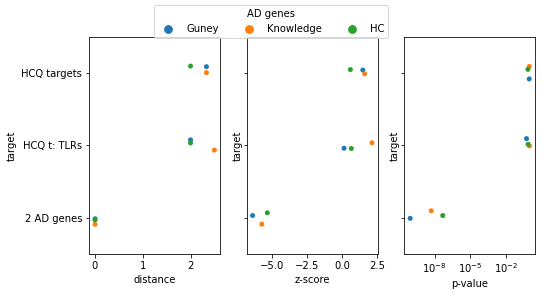

In [38]:
def plot_summary(data=prox):
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(8, 4))
    sns.stripplot(x='distance', y='target', hue='AD genes', data=data, ax=ax[0])
    sns.stripplot(x='z-score', y='target', hue='AD genes', data=data, ax=ax[1])
    sns.stripplot(x='p-value', y='target', hue='AD genes', data=data, ax=ax[2])
    ax[2].set_xscale('log')
    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, title='AD genes')
    return((fig, ax))

fig, ax = plot_summary(data=prox)
attila_utils.savefig(fig, 'proximity-d-z-p-TLRs')

['named-figure/proximity-d-z-p.png', 'named-figure/proximity-d-z-p.pdf']

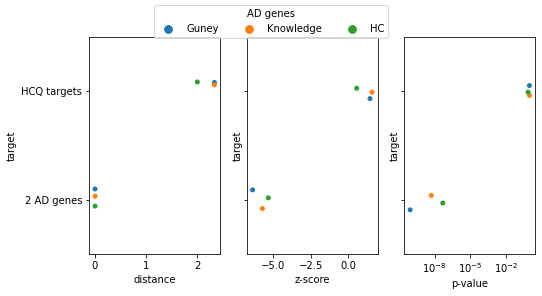

In [39]:
fig, ax = plot_summary(data=prox.drop(labels='HCQ t: TLRs', axis=0, level='target'))
attila_utils.savefig(fig, 'proximity-d-z-p')

## TODO

* Download and parse drugbank. See [drugbank-downloader](https://pypi.org/project/drugbank-downloader/)
* deploy `wrappers.calculate_proximity` to cloud

In [40]:
%connect_info

{
  "shell_port": 43185,
  "iopub_port": 37591,
  "stdin_port": 42311,
  "control_port": 39115,
  "hb_port": 39193,
  "ip": "127.0.0.1",
  "key": "c7061a9c-940e9d7e1f74f220cfaa5b16",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2186bc4d-02ab-422f-ada2-ebe35d7bb6f8.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
